In [ ]:
import pandas as pd

# Load datasets
df_players = pd.read_csv('games-data.csv')
df_metadata = pd.read_csv('Steamdb.csv')

# First, let's verify the exact column names in both files
print("Columns in games-data.csv:", df_players.columns.tolist())
print("Columns in Steamdb.csv:", df_metadata.columns.tolist())

# Find the correct name columns (case-insensitive check)
def find_name_column(df):
    for col in df.columns:
        if col.lower() == 'name':
            return col
    return None

players_name_col = find_name_column(df_players)
metadata_name_col = find_name_column(df_metadata)

if not players_name_col or not metadata_name_col:
    raise ValueError("Could not find 'name' column in one or both DataFrames")

# Standardize both to 'name' (lowercase)
df_players = df_players.rename(columns={players_name_col: 'name'})
df_metadata = df_metadata.rename(columns={metadata_name_col: 'name'})

# Now merge on the standardized column name
merged_df = pd.merge(
    df_players,
    df_metadata,
    on='name',
    how='inner'
)

# Verify the merge
print(f"Successfully merged {len(merged_df)} rows")
print("Sample of merged data:")
print(merged_df.head())

# Save the result
merged_df.to_csv('merged_data.csv', index=False)

Columns in games-data.csv: ['name', 'platform', 'r-date', 'score', 'user score', 'developer', 'genre', 'players', 'critics', 'users']
Columns in Steamdb.csv: ['ID', 'Name', 'Current', '24th Peak', 'All-Time Peak']
Successfully merged 2431 rows
Sample of merged data:
                    name      platform              r-date  score user score  \
0  Red Dead Redemption 2       XboxOne    October 26, 2018     97        7.8   
1     Grand Theft Auto V       XboxOne   November 18, 2014     97        7.8   
2     Grand Theft Auto V  PlayStation3  September 17, 2013     97        8.3   
3     Grand Theft Auto V       Xbox360  September 17, 2013     97        8.3   
4  Red Dead Redemption 2  PlayStation4    October 26, 2018     97        8.4   

       developer                                      genre    players  \
0  RockstarGames                Action Adventure,Open-World  Up to 32    
1  RockstarNorth         Action Adventure,Modern,Open-World  Up to 30    
2  RockstarNorth  Modern,Actio

Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431 entries, 0 to 2430
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           2431 non-null   object
 1   platform       2431 non-null   object
 2   r-date         2431 non-null   object
 3   score          2431 non-null   int64 
 4   user_score     2431 non-null   object
 5   developer      2431 non-null   object
 6   genre          2431 non-null   object
 7   players        2425 non-null   object
 8   critics        2431 non-null   int64 
 9   users          2431 non-null   int64 
 10  id             2431 non-null   int64 
 11  current        2431 non-null   object
 12  24th_peak      2431 non-null   object
 13  all-time_peak  2431 non-null   object
dtypes: int64(4), object(10)
memory usage: 266.0+ KB
None

Summary Statistics:
             score      critics         users           id
count  2431.000000  2431.000000   2431.000000  2431

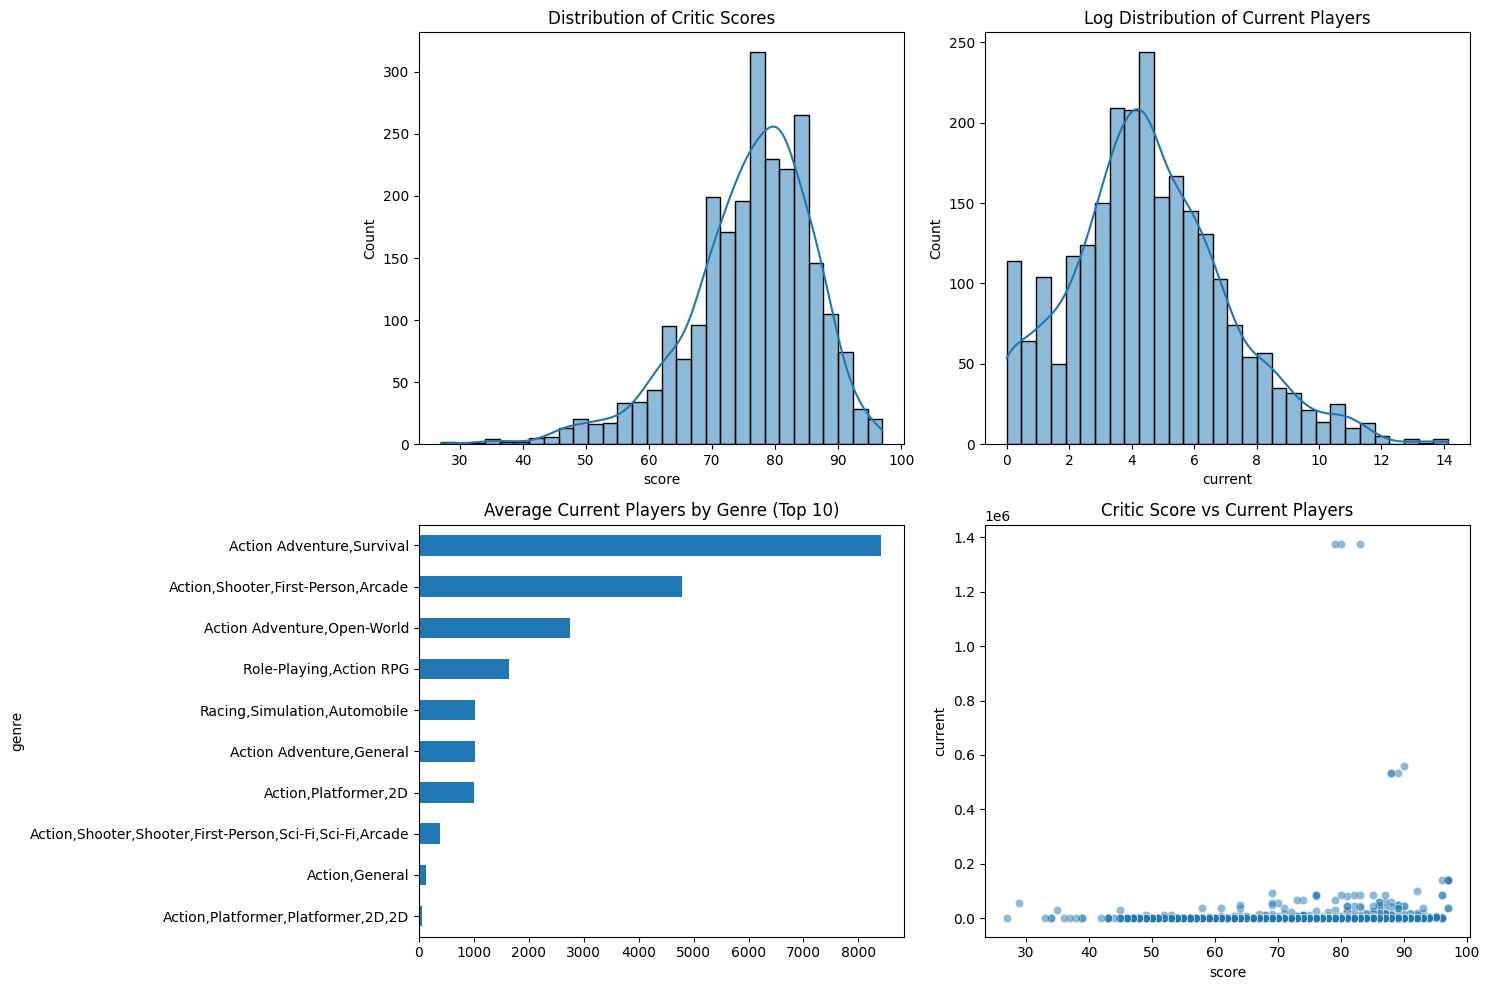

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Load merged data
df = pd.read_csv('merged_data.csv')

# Clean column names (remove spaces, standardize case)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# 1. Basic info
print("Data Structure:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

# 2. Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# 3. Clean and analyze genre data
print("\nGenre Distribution:")
df['genre'] = df['genre'].str.strip()  # Clean whitespace
print(df['genre'].value_counts())

# 4. Clean numerical columns (players, current, etc.)
def clean_numeric(col):
    return pd.to_numeric(col.astype(str).str.replace(',', ''), errors='coerce')

numeric_cols = ['players', 'current', '24th_peak', 'all-time_peak']
for col in numeric_cols:
    df[col] = clean_numeric(df[col])

# 5. Visualizations
plt.figure(figsize=(15, 10))

# A. Score distribution
plt.subplot(2, 2, 1)
sns.histplot(df['score'], bins=30, kde=True)
plt.title('Distribution of Critic Scores')

# B. Current players distribution (log scale)
plt.subplot(2, 2, 2)
sns.histplot(np.log1p(df['current'].dropna()), bins=30, kde=True)
plt.title('Log Distribution of Current Players')

# C. Top genres by average players
plt.subplot(2, 2, 3)
top_genres = df['genre'].value_counts().nlargest(10).index
genre_means = df[df['genre'].isin(top_genres)].groupby('genre')['current'].mean().sort_values()
genre_means.plot(kind='barh')
plt.title('Average Current Players by Genre (Top 10)')

# D. Score vs Players
plt.subplot(2, 2, 4)
sns.scatterplot(x='score', y='current', data=df, alpha=0.5)
plt.title('Critic Score vs Current Players')

plt.tight_layout()
plt.show()


=== Hypothesis 1: Score vs Player Count ===
Kruskal-Wallis H-statistic: 244.02, p-value: 0.0000
Significant differences exist between score tiers
Installing scikit_posthocs...

Post-hoc Dunn test results:
                <70         70-80         80-90           90+
<70    1.000000e+00  3.251585e-10  4.114164e-38  2.820562e-30
70-80  3.251585e-10  1.000000e+00  4.626350e-15  1.415739e-18
80-90  4.114164e-38  4.626350e-15  1.000000e+00  8.934712e-08
90+    2.820562e-30  1.415739e-18  8.934712e-08  1.000000e+00


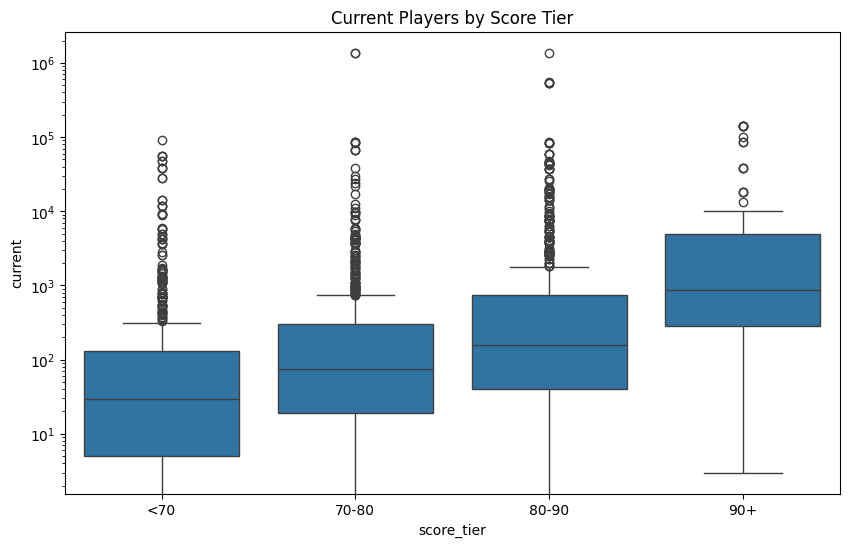

In [ ]:
# Hypothesis 1: Do higher-rated games have more players?
print("\n=== Hypothesis 1: Score vs Player Count ===")

# Create score tiers
df['score_tier'] = pd.cut(df['score'],
                         bins=[0, 70, 80, 90, 100],
                         labels=['<70', '70-80', '80-90', '90+'])

# Kruskal-Wallis test (non-parametric ANOVA)
groups = [group['current'].dropna() for name, group in df.groupby('score_tier', observed=True)]  # Added observed=True
h_stat, p_val = stats.kruskal(*groups)

print(f"Kruskal-Wallis H-statistic: {h_stat:.2f}, p-value: {p_val:.4f}")
if p_val < 0.05:
    print("Significant differences exist between score tiers")

    # Install scikit_posthocs if needed
    try:
        from scikit_posthocs import posthoc_dunn
    except ModuleNotFoundError:
        print("Installing scikit_posthocs...")
        !pip install scikit_posthocs
        from scikit_posthocs import posthoc_dunn

    # Post-hoc Dunn test
    dunn_results = posthoc_dunn(df, val_col='current', group_col='score_tier')
    print("\nPost-hoc Dunn test results:")
    print(dunn_results)

    # Visualize the differences
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='score_tier', y='current', data=df)
    plt.yscale('log')
    plt.title('Current Players by Score Tier')
    plt.show()
else:
    print("No significant difference between score tiers")


=== Hypothesis 2: Genre Popularity ===
Kruskal-Wallis H-statistic: 30.23, p-value: 0.0000

Significant differences exist between genres


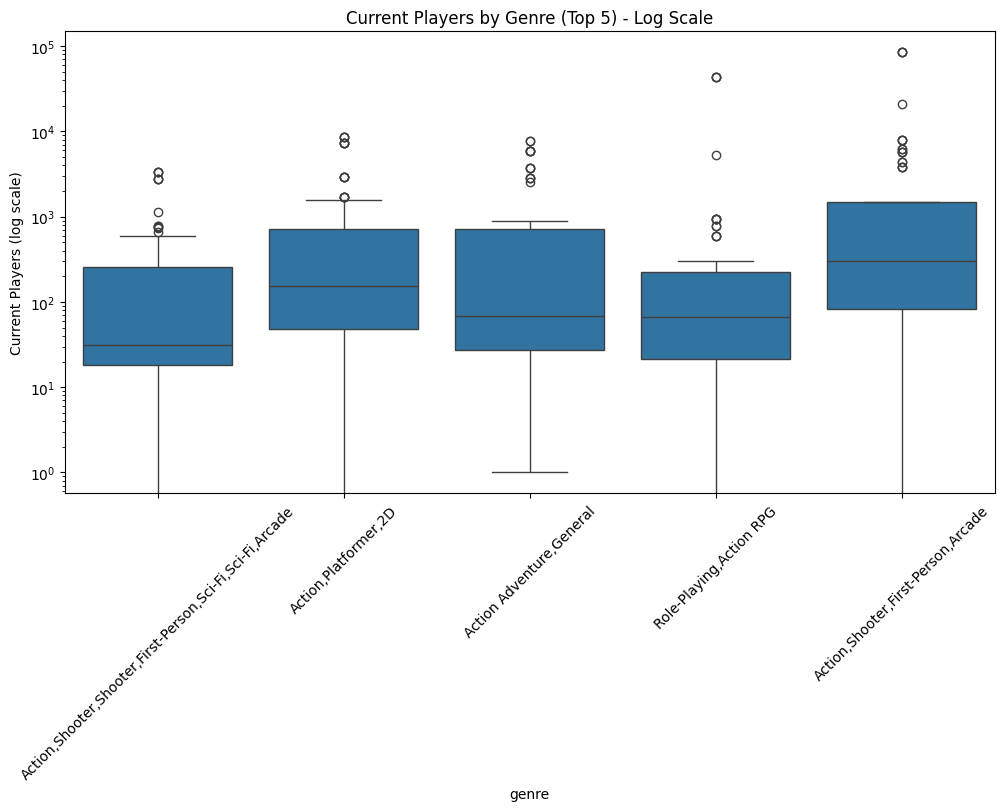


Pairwise comparisons (Mann-Whitney U with Bonferroni correction):
Bonferroni corrected alpha level: 0.0050

Pairwise Test Results:
                                                                                    Comparison  U-statistic  p-value  Significant
                                               Role-Playing,Action RPG vs Action,Platformer,2D       3331.0 0.022792        False
                                 Role-Playing,Action RPG vs Action,Shooter,First-Person,Arcade       2080.0 0.000006         True
           Role-Playing,Action RPG vs Action,Shooter,Shooter,First-Person,Sci-Fi,Sci-Fi,Arcade       3640.5 0.166757        False
                                           Role-Playing,Action RPG vs Action Adventure,General       2819.5 0.340016        False
                                    Action,Platformer,2D vs Action,Shooter,First-Person,Arcade       2845.0 0.036153        False
              Action,Platformer,2D vs Action,Shooter,Shooter,First-Person,Sci-Fi,Sci-Fi,

In [ ]:
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Hypothesis 2: Are certain genres more popular?
print("\n=== Hypothesis 2: Genre Popularity ===")

# Select top 5 genres with sufficient data
top_5_genres = df['genre'].value_counts().nlargest(5).index
genre_groups = [df[df['genre']==g]['current'].dropna() for g in top_5_genres]

# Kruskal-Wallis test
h_stat, p_val = stats.kruskal(*genre_groups)
print(f"Kruskal-Wallis H-statistic: {h_stat:.2f}, p-value: {p_val:.4f}")

if p_val < 0.05:
    print("\nSignificant differences exist between genres")

    # Visual comparison
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='genre', y='current', data=df[df['genre'].isin(top_5_genres)])
    plt.yscale('log')
    plt.title('Current Players by Genre (Top 5) - Log Scale')
    plt.ylabel('Current Players (log scale)')
    plt.xticks(rotation=45)
    plt.show()

    # Pairwise comparisons with Bonferroni correction
    print("\nPairwise comparisons (Mann-Whitney U with Bonferroni correction):")
    alpha = 0.05
    n_comparisons = len(list(combinations(top_5_genres, 2)))
    bonferroni_alpha = alpha / n_comparisons
    print(f"Bonferroni corrected alpha level: {bonferroni_alpha:.4f}")

    results = []
    for genre1, genre2 in combinations(top_5_genres, 2):
        group1 = df[df['genre'] == genre1]['current'].dropna()
        group2 = df[df['genre'] == genre2]['current'].dropna()
        u_stat, p_val = stats.mannwhitneyu(group1, group2)
        is_significant = p_val < bonferroni_alpha
        results.append({
            'Comparison': f"{genre1} vs {genre2}",
            'U-statistic': u_stat,
            'p-value': p_val,
            'Significant': is_significant
        })

    # Display results in a clean table
    results_df = pd.DataFrame(results)
    print("\nPairwise Test Results:")
    print(results_df.to_string(index=False))

    # Visualize significant differences
    if results_df['Significant'].any():
        print("\nSummary of Significant Differences:")
        for _, row in results_df[results_df['Significant']].iterrows():
            print(f"- {row['Comparison']} (p = {row['p-value']:.4f})")
    else:
        print("No significant pairwise differences after correction")
else:
    print("No significant difference between genres")

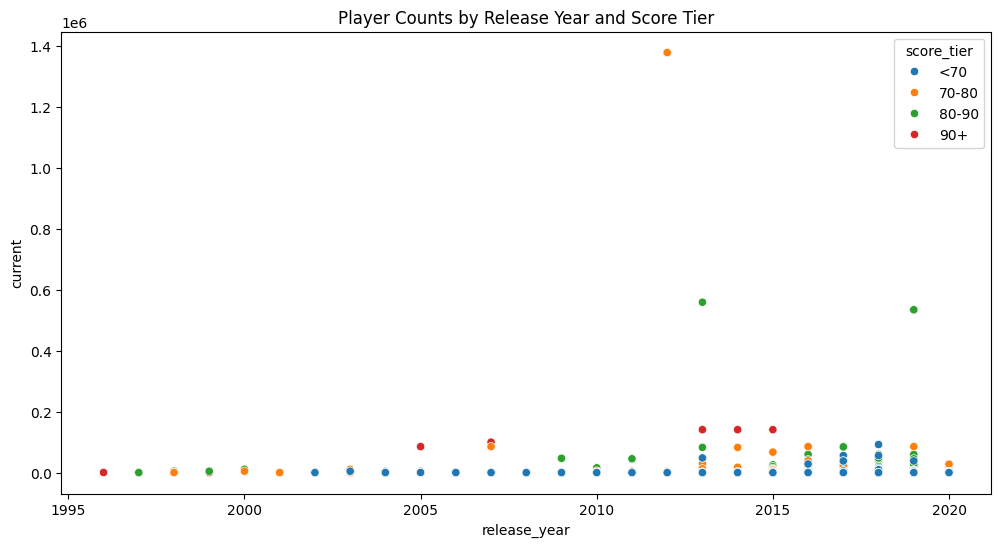

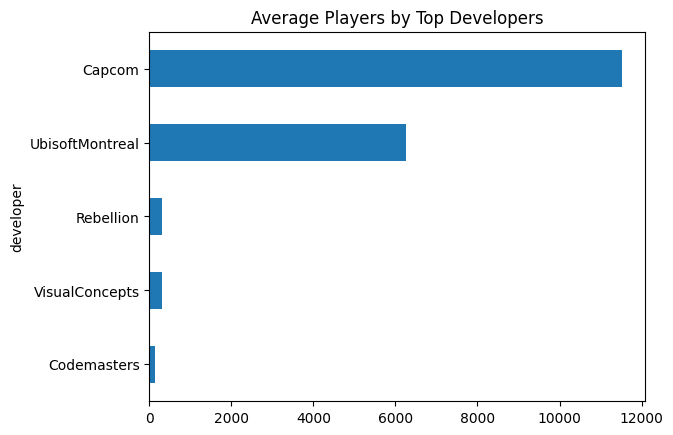

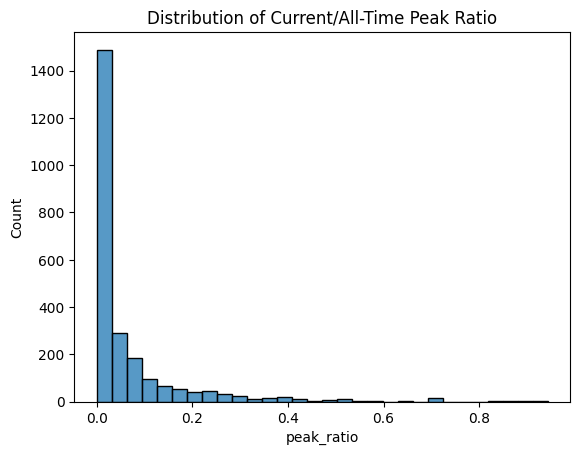

In [ ]:
# A. Temporal Analysis (if release date is available)
df['r-date'] = pd.to_datetime(df['r-date'])  # Convert to datetime
df['release_year'] = df['r-date'].dt.year

# Plot players vs. release year
plt.figure(figsize=(12, 6))
sns.scatterplot(x='release_year', y='current', data=df, hue='score_tier')
plt.title('Player Counts by Release Year and Score Tier')
plt.show()

# B. Developer/Publisher Analysis
top_devs = df['developer'].value_counts().nlargest(5).index
df[df['developer'].isin(top_devs)].groupby('developer')['current'].mean().sort_values().plot(kind='barh')
plt.title('Average Players by Top Developers')
plt.show()

# C. Peak Analysis
df['peak_ratio'] = df['current'] / df['all-time_peak']
sns.histplot(df['peak_ratio'].dropna(), bins=30)
plt.title('Distribution of Current/All-Time Peak Ratio')
plt.show()

In [ ]:
# A. Do games with higher peak ratios have better scores?
high_ratio = df[df['peak_ratio'] > df['peak_ratio'].median()]['score']
low_ratio = df[df['peak_ratio'] <= df['peak_ratio'].median()]['score']
u_stat, p_val = stats.mannwhitneyu(high_ratio, low_ratio)
print(f"Do high-engagement games have better scores? U={u_stat:.1f}, p={p_val:.4f}")

# B. Is there a platform effect?
platform_groups = [group['current'] for _, group in df.groupby('platform')]
h_stat, p_val = stats.kruskal(*platform_groups)
print(f"\nPlatform differences: H={h_stat:.1f}, p={p_val:.4f}")

Do high-engagement games have better scores? U=904362.0, p=0.0000

Platform differences: H=119.8, p=0.0000


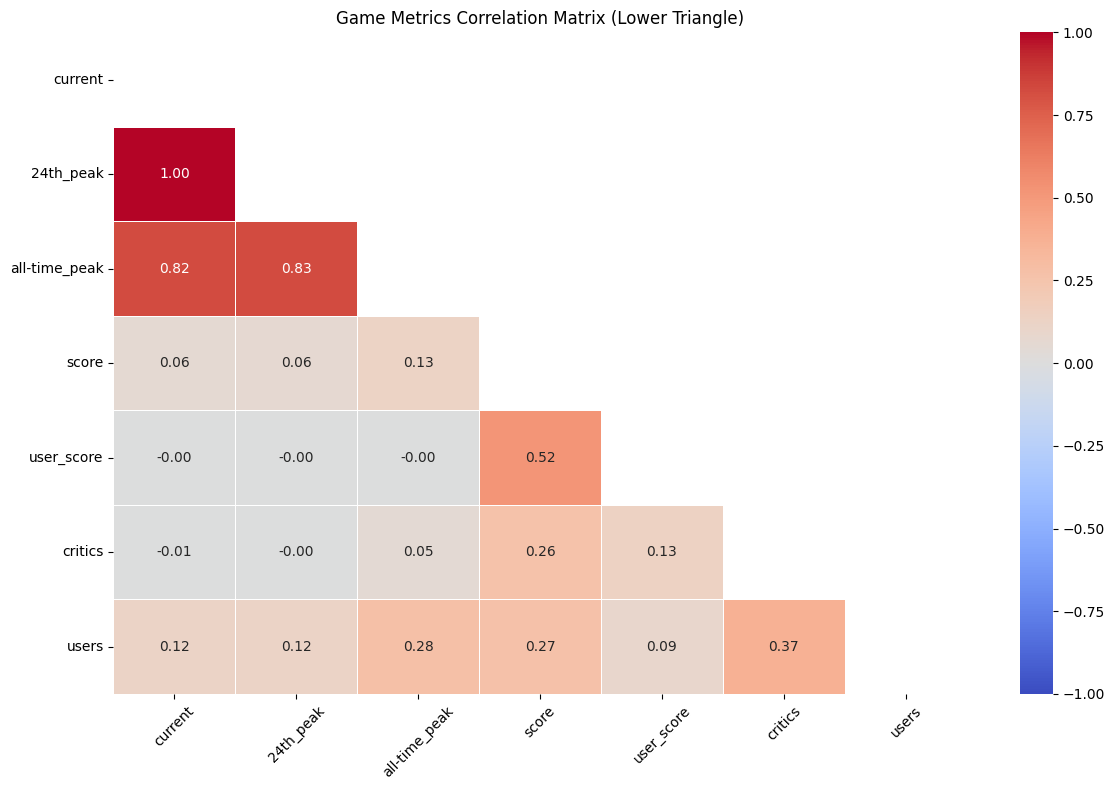

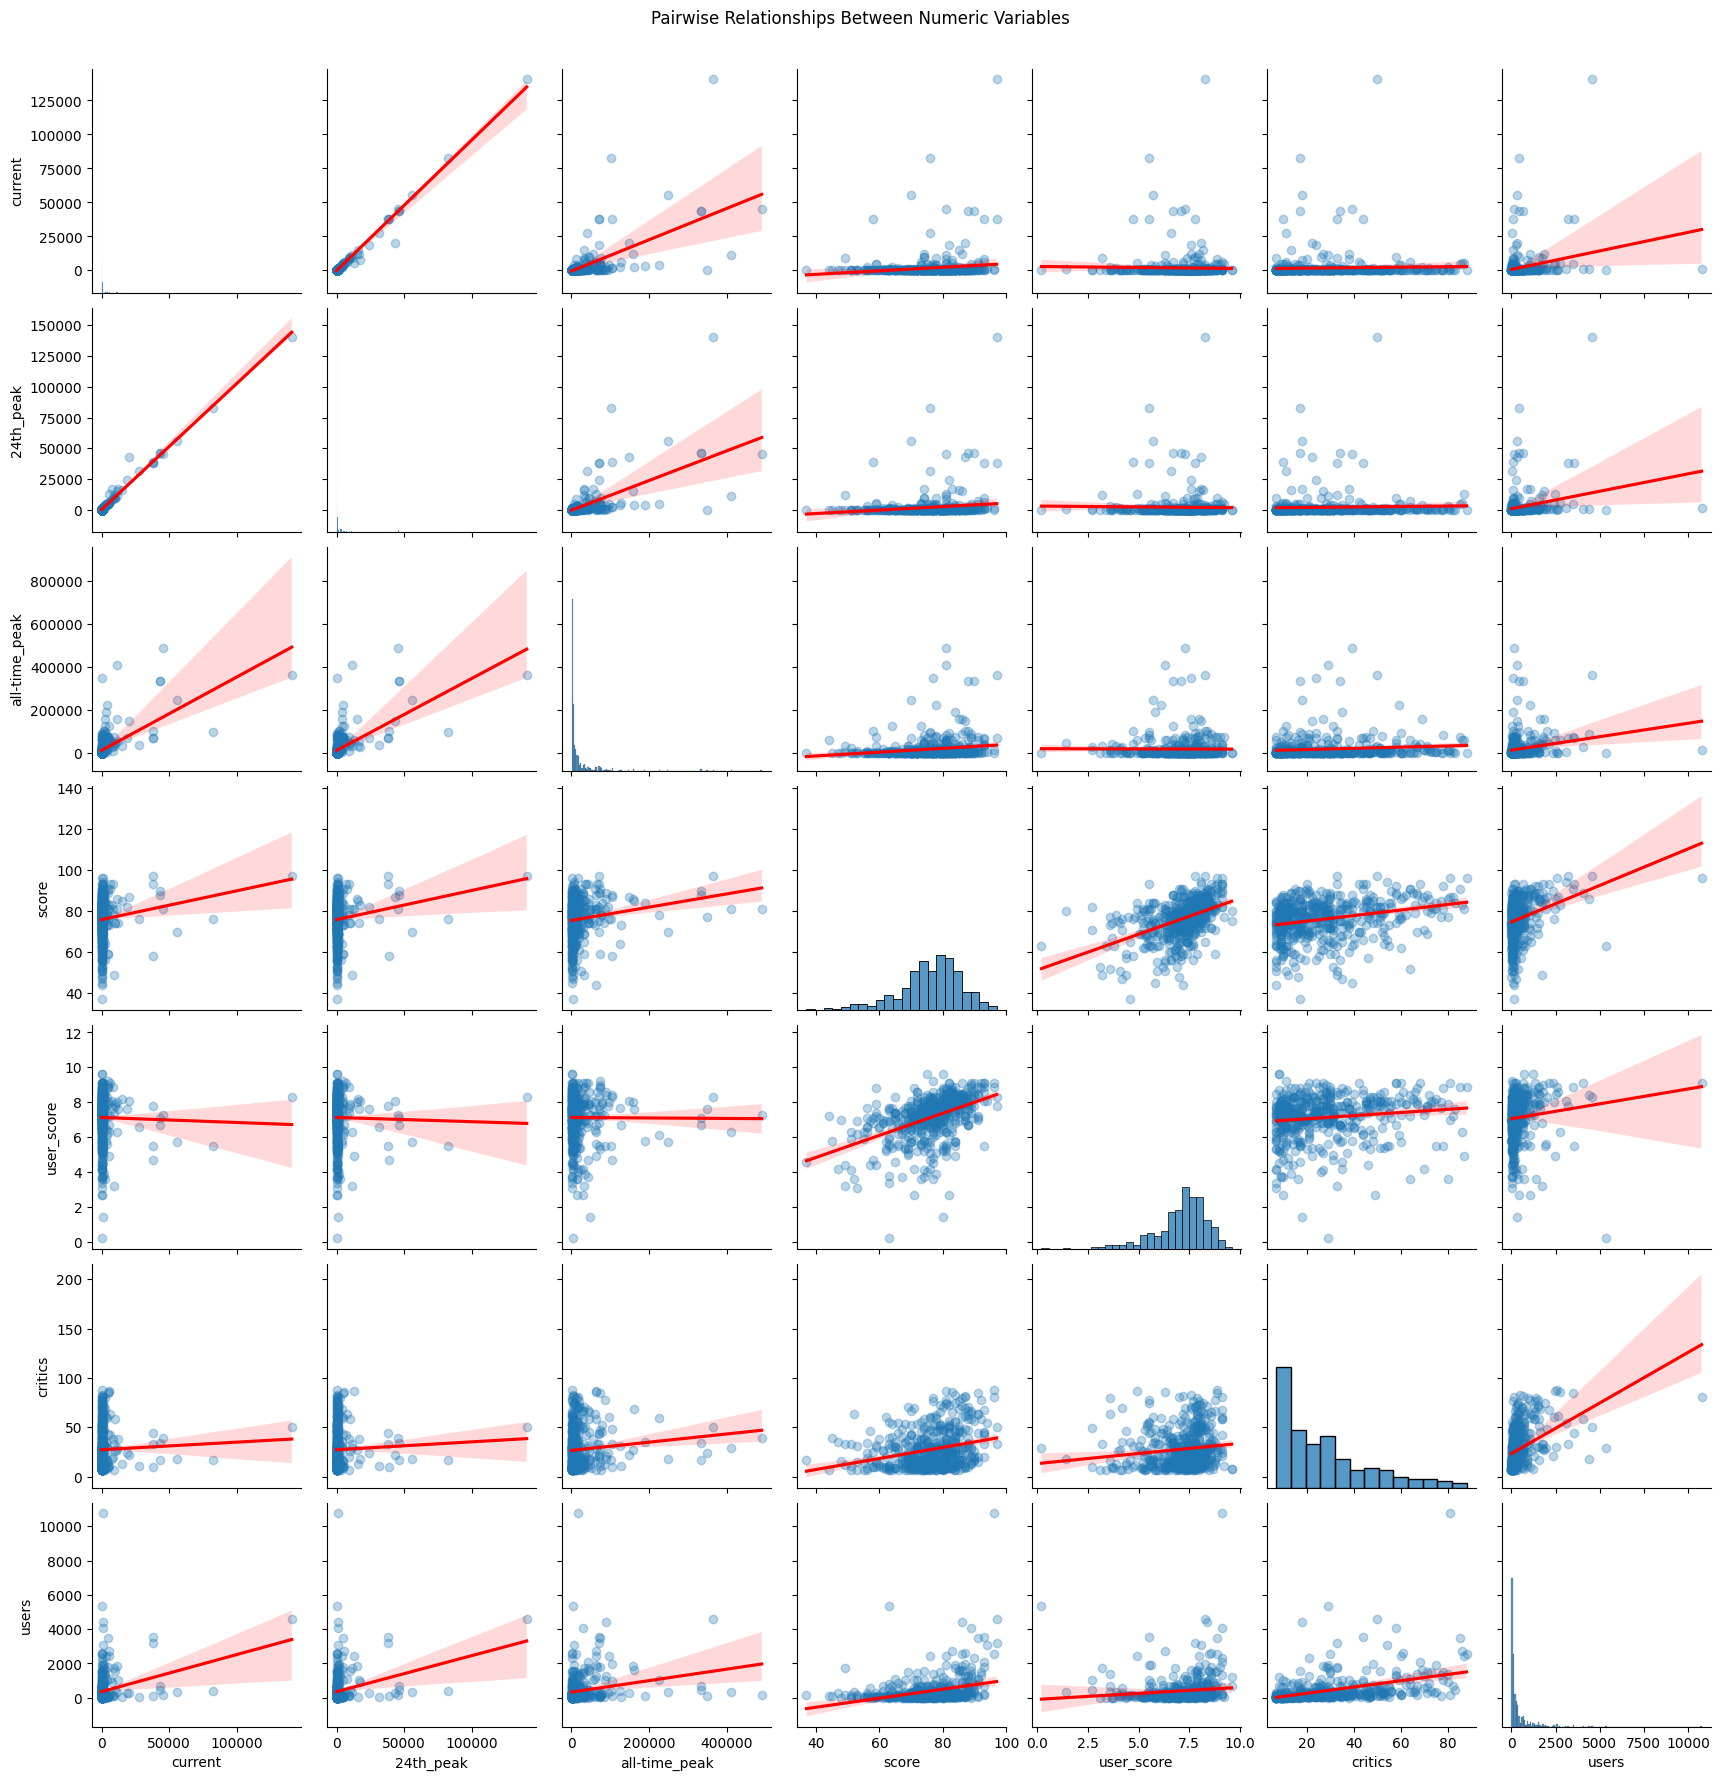

In [ ]:
# First, let's clean the numeric columns properly
def clean_numeric(col):
    # Convert to string, remove commas/percent signs, handle 'tbd' as NaN
    return pd.to_numeric(
        col.astype(str).str.replace(',', '').str.replace('%', '').replace('tbd', np.nan),
        errors='coerce'
    )

# Apply cleaning to all numeric columns
numeric_cols = ['current', '24th_peak', 'all-time_peak', 'score', 'user_score', 'critics', 'users']
for col in numeric_cols:
    df[col] = clean_numeric(df[col])

# Now compute correlations
corr_matrix = df[numeric_cols].corr()

# Visualize with improved settings
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    mask=mask,
    vmin=-1,
    vmax=1,
    linewidths=0.5
)
plt.title('Game Metrics Correlation Matrix (Lower Triangle)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show pairplot for key relationships
sns.pairplot(
    df[numeric_cols].sample(500) if len(df) > 500 else df[numeric_cols],
    kind='reg',
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.3}}
)
plt.suptitle('Pairwise Relationships Between Numeric Variables', y=1.02)
plt.show()

In [ ]:
# Z-score method for player counts
df['current_z'] = stats.zscore(df['current'])
outliers = df[abs(df['current_z']) > 3]
print(f"Found {len(outliers)} player count outliers:")
print(outliers[['name', 'current', 'genre']])

Found 7 player count outliers:
                                  name  current  \
114                             Dota 2   558728   
155                       Apex Legends   534000   
199                       Apex Legends   534000   
214                       Apex Legends   534000   
629   Counter-Strike: Global Offensive  1377518   
934   Counter-Strike: Global Offensive  1377518   
1007  Counter-Strike: Global Offensive  1377518   

                                                  genre  
114        General,Fantasy,MOBA,Strategy,Real-Time,MOBA  
155                Action,Shooter,First-Person,Tactical  
199                Action,Shooter,First-Person,Tactical  
214                Action,Shooter,First-Person,Tactical  
629   Action,Shooter,Shooter,First-Person,Modern,Tac...  
934   Action,Shooter,Shooter,First-Person,Modern,Tac...  
1007  Action,Shooter,Shooter,First-Person,Modern,Tac...  


Numeric features used (post‐impute): ['score', 'user_score', 'players', 'critics', 'users', 'id', 'current', '24th_peak', 'all-time_peak', 'release_year', 'peak_ratio', 'current_z']
=== Logistic Regression ===
Accuracy: 0.9917763157894737
ROC-AUC : 0.9997727666204985
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       304
           1       0.99      0.99      0.99       304

    accuracy                           0.99       608
   macro avg       0.99      0.99      0.99       608
weighted avg       0.99      0.99      0.99       608

=== Random Forest ===
Accuracy: 1.0
ROC-AUC : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       304
           1       1.00      1.00      1.00       304

    accuracy                           1.00       608
   macro avg       1.00      1.00      1.00       608
weighted avg       1.00      1.00      1.00       608



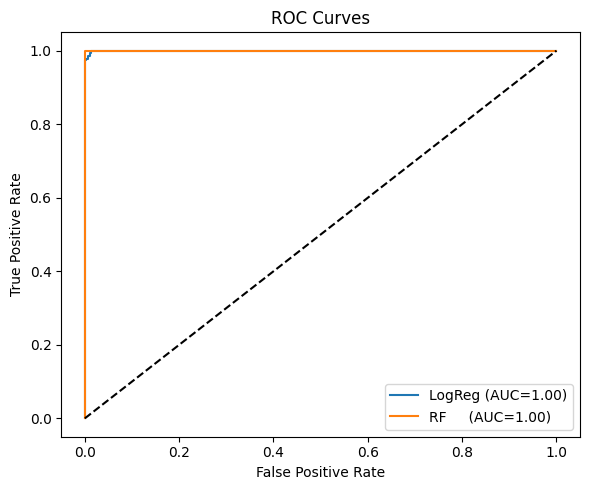

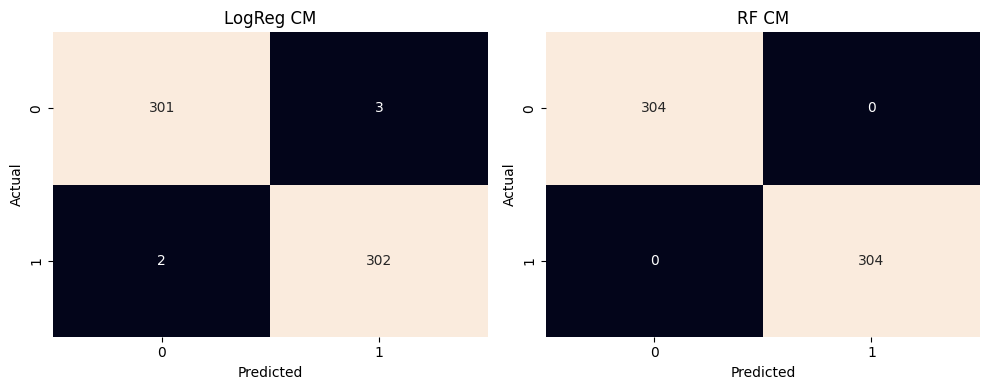

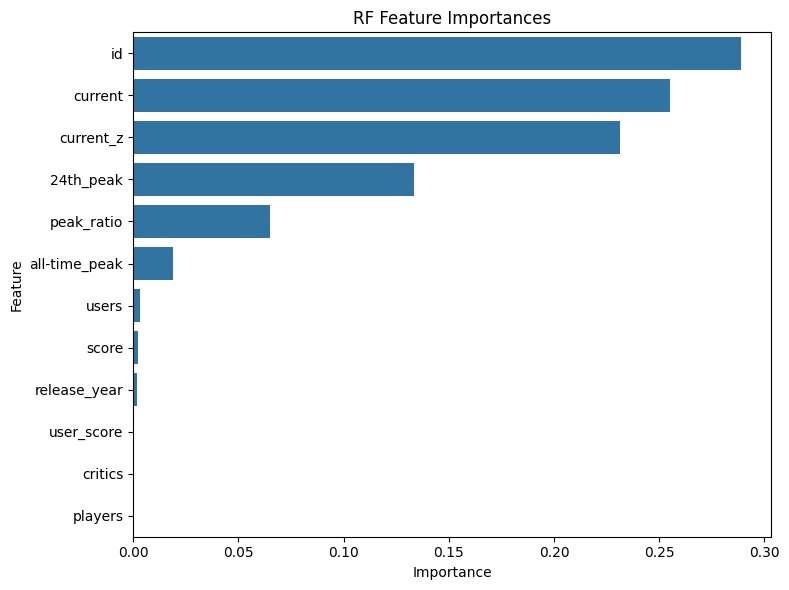

Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Tuned RF ROC-AUC: 1.0


In [ ]:
# =====================================
# Part 7: Machine Learning + Plots
# =====================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import LogisticRegression
from sklearn.ensemble         import RandomForestClassifier
from sklearn.metrics          import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    confusion_matrix,
)

# — 7.0 Ensure log_current exists —
if 'log_current' not in df.columns:
    df['log_current'] = np.log1p(df['current'])

# — 7.1 Create binary target —
df['high_engagement'] = (df['log_current'] > df['log_current'].median()).astype(int)

# — 7.2 Auto-select only numeric features —
num_feats = df.select_dtypes(include=[np.number]).columns.tolist()
for c in ['high_engagement', 'log_current']:
    if c in num_feats:
        num_feats.remove(c)

X = df[num_feats]
y = df['high_engagement']

# — 7.2.1 Impute any remaining NaNs with the median of each column —
X = X.fillna(X.median())

print("Numeric features used (post‐impute):", X.columns.tolist())

# — 7.3 Train/Test split —
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# — 7.4 Scale features for Logistic Regression —
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# — 7.5 Logistic Regression —
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)
y_prob_lr = lr.predict_proba(X_test_s)[:,1]

print("=== Logistic Regression ===")
print("Accuracy:",     accuracy_score(y_test, y_pred_lr))
print("ROC-AUC :",     roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))

# — 7.6 Random Forest (no scaling) —
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("=== Random Forest ===")
print("Accuracy:",     accuracy_score(y_test, y_pred_rf))
print("ROC-AUC :",     roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))

# =====================================
# 7.7 ROC Curve Plot
# =====================================
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={roc_auc_score(y_test,y_prob_lr):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RF     (AUC={roc_auc_score(y_test,y_prob_rf):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()

# =====================================
# 7.8 Confusion Matrix Heatmaps
# =====================================
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(cm_lr, annot=True, fmt='d', ax=axes[0], cbar=False)
axes[0].set(title='LogReg CM', xlabel='Predicted', ylabel='Actual')
sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[1], cbar=False)
axes[1].set(title='RF CM',    xlabel='Predicted', ylabel='Actual')
plt.tight_layout()
plt.show()

# =====================================
# 7.9 Random Forest Feature Importances
# =====================================
importances = rf.feature_importances_
feat_names = X.columns
order = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[order], y=feat_names[order])
plt.title('RF Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# =====================================
# 7.10 (Optional) RF Grid-Search
# =====================================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth':    [None, 10, 20],
    'min_samples_split': [2, 5]
}
gs = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid, cv=3, scoring='roc_auc', n_jobs=-1
)
gs.fit(X_train, y_train)
print("Best RF params:", gs.best_params_)
print("Tuned RF ROC-AUC:", roc_auc_score(y_test, gs.best_estimator_.predict_proba(X_test)[:,1]))
